In [ ]:
import numpy as np
import pandas as pd

In [ ]:
pd.set_option('display.max_columns', None)

# **Input Data Creation**

# **Deriving James-Stein Shrinkage estimation Coefficient**

In [ ]:
def alpha_numerator(Z,S):
  s = 0
  T = Z.shape[1]
  for k in range(T):
    z = Z[:,k][:,np.newaxis]
    X = z @ z.T - S
    s += np.trace(X @ X)
  s /= (T**2)
  return s


def mean_shrinkage_JS(m_estim,S_estim,return_array):
  T  = return_array.shape[0]
  N = m_estim.shape[0]
  m = m_estim[:,np.newaxis]
  o = np.ones(N)[:,np.newaxis]
  iS = np.linalg.inv(S_estim)
  b = (o.T @ m / N)*o
  N_eff = np.trace(S_estim)/ np.max(np.linalg.eigvalsh(S_estim))
  alpha_num = max(N_eff - 3,0) ## it should not get negative
  alpha_den = T * (m - b).T @ iS @ (m - b)
  alpha = alpha_num/alpha_den
  m_shrunk = b + max(1 - alpha, 0) * (m - b)
  m_shrunk = m_shrunk[:, 0]

  return m_shrunk


def cov_shrinkage_LW(m_estim,S_estim,return_array):
  N = S_estim.shape[0]
  s2_avg = np.trace(S_estim)/N
  B = s2_avg * np.eye(N)
  Z = return_array.T  - m_estim[:,np.newaxis]
  alpha_num = alpha_numerator(Z,S_estim)
  alpha_den = np.trace((S_estim - B) @ (S_estim - B))
  alpha = alpha_num/alpha_den
  S_shrunk = (1 - alpha) * S_estim + alpha * B

  return S_shrunk

In [ ]:
def compute_inputs(
        list_df_prices,
        sample_period='W',
        investment_horizon=1,
        show_histograms=False,
        shrinkage=False,
        security_num=None,
        return_log=False
    ):
    map_period = {
        'W': 52
    }

    # We can generate return distribution based on multiple periods of price data
    if not isinstance(list_df_prices, list):
        list_df_prices = [list_df_prices]

    df_weekly_log_returns = pd.DataFrame()
    for df_prices in list_df_prices:
        # PREPROC: Remove factors
        if security_num is not None:
            df_prices = df_prices.iloc[:, 0:security_num]

        # 1. Compute weekly logarithmic return
        df_weekly_prices = df_prices.resample(sample_period).last()
        df_weekly_log_returns_part = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
        df_weekly_log_returns_part = df_weekly_log_returns_part.dropna(how='all')
        df_weekly_log_returns_part = df_weekly_log_returns_part.fillna(0)

        df_weekly_log_returns = pd.concat([df_weekly_log_returns, df_weekly_log_returns_part], ignore_index=True)

    if show_histograms:
        df_weekly_log_returns.hist(bins=50)

    # 2. Compute the distribution of weekly logarithmic return
    return_array = df_weekly_log_returns.to_numpy()
    T = return_array.shape[0]
    m_weekly_log = np.mean(return_array, axis=0)
    S_weekly_log = np.cov(return_array.transpose())

    # Apply shrinkage if needed
    if shrinkage:
      m_weekly_log = mean_shrinkage_JS(m_weekly_log, S_weekly_log, return_array)
      S_weekly_log = cov_shrinkage_LW(m_weekly_log, S_weekly_log, return_array)

    # 3. Project the distribution to the investment horizon
    scale_factor = investment_horizon * map_period[sample_period]
    m_log = scale_factor * m_weekly_log
    S_log = scale_factor * S_weekly_log

    if return_log:
        return m_log, S_log

    # 4. Compute the distribution of yearly linear return
    p_0 = np.ones(len(m_log))  # We use a dummy price here to see the method in two steps. It will be canceled out later.
    m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
    S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)

    m = 1 / p_0 * m_P - 1
    S = 1 / np.outer(p_0, p_0) * S_P

    return m, S

In [ ]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore")

# **Getting the Data First**

In [ ]:
from datetime import datetime
import yfinance as yf
#import matplotlib.pyplot as plt

# initialize parameters
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 1, 1)

assets = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "FB", "TSLA", "BRK-A", "BRK-B", "JNJ",
    "JPM", "PG", "NVDA", "V", "MA", "HD", "DIS", "PYPL", "INTC", "UNH", "CRM",
    "BAC", "ADBE", "KO", "CMCSA", "NFLX", "NKE", "PEP", "XOM", "CSCO", "WMT",
    "ABBV", "ABT", "MRK", "CVX", "T", "MCD", "BABA", "ORCL", "IBM", "PM",
    "WFC", "VZ", "TMO", "COST", "PFE", "WBA", "C", "HON", "UPS", "NEE",
    "LIN", "LLY", "AMGN", "MDT", "UNP", "SBUX", "DHR", "ACN", "TXN", "AVGO",
    "LOW", "CAT", "QCOM", "GS", "CHTR", "INTU", "BKNG", "BDX", "RTX", "USB",
    "ISRG", "CI", "SYK", "BDX", "ADP", "ZTS", "LMT", "MMM", "AMD", "ANTM",
    "NOW", "CSX", "VRTX", "SCHW", "ZM", "CB", "RTX", "PLD", "TGT", "MU",
    "DE", "PNC", "ICE", "FDX", "APD", "TMUS", "CCI", "ILMN", "EW"
]

# get the data
raw_data = yf.download(assets, start = start_date,
                   end = end_date)

data = raw_data.loc[:,('Adj Close', slice(None))]
data_volume = raw_data.loc[:,('Volume', slice(None))]

scrip = []
try:
  for index in range(data.shape[0]-1):
    scrip.append(data.columns[index][1])
except:
  print("Index Out")

data.columns = scrip
data_volume.columns = scrip
data

[*********************100%%**********************]  98 of 98 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['FB', 'ANTM']: Exception('%ticker%: No timezone found, symbol may be delisted')


Index Out


,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,ANTM,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FB,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,127.002113,92.173607,103.105194,245.115601,485.339996,159.097137,92.300003,204.389328,159.331497,NaN,249.729462,391.186737,224.827728,27.922979,234.449051,2164.080078,343525.0,228.449997,53.118793,170.039978,142.306961,137.190857,647.030029,195.227249,46.646595,363.143188,220.309998,40.189526,28.243383,73.948395,257.993286,195.430481,177.102798,88.919998,NaN,240.263306,86.412003,86.306503,245.939224,245.347702,195.985214,101.472198,108.795441,367.760010,45.371323,364.220215,266.666656,143.276245,114.875870,48.158413,247.778168,158.981491,317.351105,151.289627,345.084106,196.562454,106.571243,148.233978,70.257332,211.605316,72.796799,69.310257,522.859985,135.820648,526.830017,130.840118,60.553730,132.712158,32.333988,127.131248,89.277626,69.568398,132.790329,231.919998,139.010635,63.610142,96.452766,50.570431,231.214859,17.343355,166.215622,468.583130,131.854401,243.256668,148.273880,335.248779,189.960175,147.621353,40.665340,212.716629,229.429993,48.899704,35.157166,27.566046,139.870636,36.027859,359.980011,159.686447
2021-01-05,128.572342,93.126732,104.380905,246.511017,485.690002,158.654602,92.769997,205.381241,160.925507,NaN,262.942169,393.836212,237.211243,28.136841,234.757660,2188.070068,341820.0,227.470001,54.496662,171.430923,142.421021,137.730728,636.590027,193.054031,46.368267,358.930542,221.520004,40.207813,28.721649,75.947479,264.393951,200.280579,177.860336,88.440002,NaN,240.253815,87.045998,87.002502,251.442657,247.327774,196.465912,103.273376,109.025894,374.899994,46.229965,361.447144,268.350006,144.960739,115.500931,47.629009,251.665131,159.769211,321.172485,151.799026,341.088318,197.740601,107.425507,147.983856,70.378838,211.809433,75.952469,69.823868,520.799988,136.916138,531.969971,133.746063,59.803337,133.107697,32.667770,127.943016,89.417061,70.328102,132.087006,234.910004,142.689484,64.530396,96.770851,50.580017,231.833939,17.237316,168.779556,474.442657,131.276932,245.036667,149.361603,330.740326,192.290146,145.566574,40.797604,209.541885,228.580002,48.675365,34.953358,28.336409,139.126129,37.764145,360.829987,160.799225
2021-01-06,124.244385,92.322266,104.163567,249.206238,466.309998,158.098999,90.330002,210.331818,156.919006,NaN,270.000183,391.407562,224.590897,29.894234,237.198456,2249.810059,346189.0,230.270004,57.632214,180.971481,149.197540,134.031006,624.510010,198.748001,46.906357,353.466370,216.149994,40.591782,29.485590,78.391762,279.894318,206.916595,178.538116,87.199997,NaN,240.614426,86.764503,86.143997,265.011108,248.740860,200.047272,105.852348,111.138420,376.549988,46.677563,353.735504,264.263336,146.324860,120.924377,46.113789,259.927216,157.847961,320.472687,153.827133,341.215881,197.291794,109.179962,150.234924,71.489594,206.317368,75.804993,73.241753,500.489990,138.001938,507.250000,125.861336,59.660320,131.479507,32.386681,129.289764,87.297607,70.422005,139.343002,226.830002,141.528748,65.329834,97.472488,55.027462,234.532852,17.573107,176.780121,481.881256,130.958328,251.993332,150.101944,344.620300,196.313705,145.133957,43.213535,207.695663,226.649994,49.265316,36.541370,30.341211,139.994736,38.727768,344.410004,163.161469
2021-01-07,128.484009,93.310364,105.174667,251.557495,477.739990,158.993607,95.160004,211.026169,158.108002,NaN,265.642517,407.902527,223.890305,30.554417,237.067535,2239.850098,350089.0,232.880005,58.312313,181.316879,148.133072,134.933807,629.770020,209.253372,46.999126,351.460388,217.979996,41.103756,30.182127,78.758408,288.926605,209.858170,177.99

**Removing the stocks with NAN values**

*Reasons behind it might be yahoo finance unable to fetch the data or the name of the stock on NYSE has changed*

In [ ]:
data.drop(['ANTM'],axis=1,inplace=True)

In [ ]:
data.drop(['FB'],axis=1,inplace=True)

In [ ]:
data_volume.drop(['ANTM'],axis=1,inplace=True)
data_volume.drop(['FB'],axis=1,inplace=True)

## **Getting Input Parameters**

# **To get G (risk matrix) we used cholesky's decomposition function so that we acquire a lower triangular matrix with minimum non-zero entries (Healthy for computation efficiency)**

In [ ]:
N = data.shape[1]

# Get optimization parameters
m, S = compute_inputs(data, security_num=N)

In [ ]:
G = np.linalg.cholesky(S)

In [ ]:
! pip install mosek
from mosek.fusion import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 34.1 MB/s eta 0:00:00


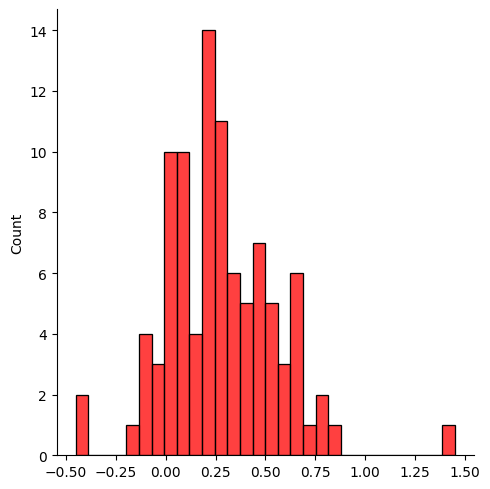

In [ ]:
import seaborn as sns
sns.displot(m,kde = False, color ='red', bins = 30)

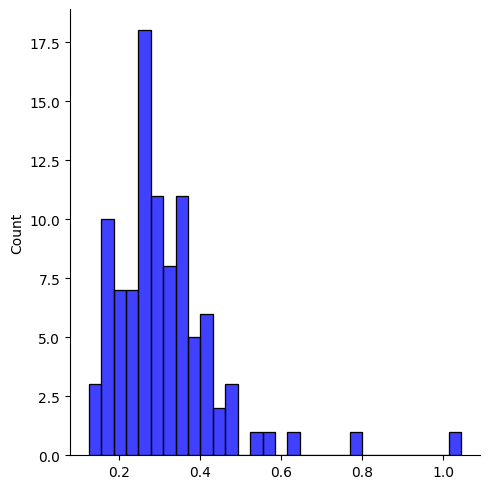

In [ ]:
sns.displot(np.sqrt(np.diag(S)),kde = False, color ='blue', bins = 30)

# **Creating a return scenario (100 simulations) per stock using Multi Variate Normal Distribution (Monte Carlo Simulation)**

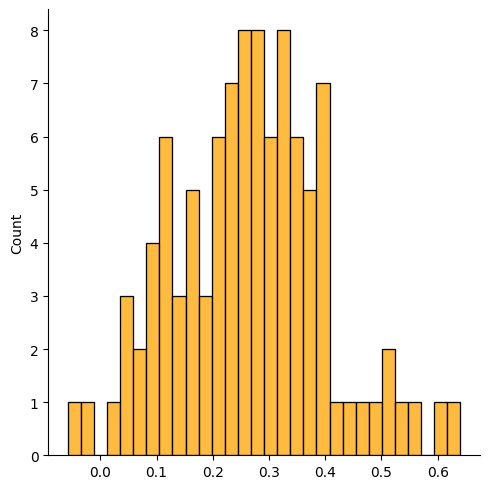

In [ ]:
# Number of simulations
num_simulations = 100

m_log, s_log = compute_inputs(data,return_log=True)

np.random.seed(12345)
scenario_log = np.random.default_rng().multivariate_normal(m_log,s_log,num_simulations)

scenario_lin = np.exp(scenario_log) - 1

weights = np.array([1/N]*N)
portfolio_return = scenario_lin*weights
portfolio_return = portfolio_return.sum(axis=1)

sns.displot(portfolio_return,kde = False, color ='orange', bins = 30)

# **Calculating Value at Risk for alpha = 0.05**

In [ ]:
# Ensure sorted in ascending order (important for accurate VaR and EVaR)
sorted_returns = np.sort(portfolio_return)

# Calculate VaR threshold
var_index = int(len(sorted_returns) * 0.05)
var_threshold = sorted_returns[var_index]
print("Value AT Risk :", var_threshold)

Value AT Risk : 0.05597702518583964


# **Calculating Entropic Value AT Risk**

*EVaR for a normal distribution N(mu, sigma) is mu + sqrt( -2 * log(alpha)) * std*

citing :
**Amir Ahmadi-Javid1
and Malihe Fallah-Tafti (Portfolio Optimization with Entropic Value-at-Risk)**

In [ ]:
## we know that our returns (X) follow normal distribution hence the formula to calculate EVAR,VAR,CVAR changes (kindly refer notes)
## this formula comes from the research paper directly

EVAR = np.mean(sorted_returns) + np.sqrt(-2 * np.log(0.05)) * np.std(sorted_returns)
print("EVAR :", EVAR)

EVAR : 0.5961846931864728


# **Portfolio Optimization**

*Handling:*

*1) Market Impact Cost*

*2) Transaction Cost*

*3) Leverage*

In [ ]:
## first formulate the problem on a page (build a system) this system will be very realistic
def evar_constraints(M,x,p,s,t):
  n = int(x.getSize())
  u = M.variable(n)
  M.constraint(Expr.hstack(u,Var.repeat(s,n),Expr.sub(x,Var.repeat(t,n))), Domain.inPExpCone())
  M.constraint(Expr.sub(Expr.dot(p,u),s),Domain.lessThan(0.0))

In [ ]:
def pos_neg(M,x,bigp):
  bigm = bigp
  ## define variable
  xp = M.variable("xp",N,Domain.greaterThan(0.0))
  xm = M.variable("xm",N,Domain.greaterThan(0.0))

  yp = M.variable("yp",N,Domain.binary())
  ym = M.variable("ym",N,Domain.binary())

  M.constraint("pos_neg",Expr.sub(x,Expr.sub(xm,xp)),Domain.equalsTo(0.0))

  M.constraint("upper_boundp",Expr.sub(Expr.mul(bigp,yp),xp),Domain.lessThan(0.0))
  M.constraint("upper_boundm",Expr.sub(Expr.mul(bigm,ym),xm),Domain.lessThan(0.0))
  M.constraint("exclusion",Expr.add([yp,ym]),Domain.lessThan(0.0))

  return xp,xm,yp,ym

def norm1_miu(M,x,bigp,Domain):
  xp,xm,yp,ym = pos_neg(M,x,bigp)
  M.constraint("Gross_Exposure",Expr.sum(Expr.add([xm,xp])),Domain)
  return xp,xm,yp,ym

In [ ]:
import sys
def model_two(N,m,deltas,vp,vm,fp,fm,bigp,pcoef,a, beta, rf, R, p,alpha):
  with Model("model_two") as M:
    ## output
    #M.setLogHandler(sys.stdout)

    ## Defining variables
    x = M.variable("x",N,Domain.unbounded())
    xf = M.variable("xf",1,Domain.unbounded()) ## we can short bonds as well
    k = M.variable("k",N,Domain.unbounded()) ## market impact cost auxiliary variable
    u = M.variable("u",N,Domain.unbounded()) ## basically this is relative entropy value
    z = M.variable("z",1,Domain.unbounded()) ## evar auxiliary variable
    t = M.variable("t",1,Domain.greaterThan(0.0)) ## this is basically the lambda which we get after optimization (minimizing function)

    evar_constraints(M,Expr.mul(-R,x),p,t,z) ## evar constraint to be considered as exponential cone

    ## calling our out of the model variables
    xp,xm,yp,ym = norm1_miu(M,x,bigp,Domain.lessThan(2.0))

    ## Defining constraints
    fixedcost = Expr.add([Expr.dot(xp,fp),Expr.dot(xm,fm)])
    varcost_term = Expr.add([Expr.dot(vp,yp),Expr.dot(vm,ym)])

    ## Defining first part of the budget
    budget_one = Expr.add([fixedcost,varcost_term,Expr.sum(x)])
    budget_two = Expr.sum(Expr.hstack(xf,Expr.dot(a,k)))

    ## assembling the entire budget together
    M.constraint("budget",Expr.add([budget_one,budget_two]),Domain.equalsTo(1.0))

    ## defining market impact cost
    M.constraint("market_impact",Expr.hstack(k,Expr.constTerm(N,1.0),x),Domain.inPPowerCone(1.0/beta))

    ## defining the evar cost term
    evar_value = Expr.sub(z,Expr.mul(t,np.log(1-alpha)))

    ## transaction penalty
    transaction_penalty = Expr.mul(pcoef,Expr.sum(Expr.add([xm,xp])))

    delta = M.parameter()

    ## now atlast defining objective function
    M.objective('obj',ObjectiveSense.Maximize, Expr.sub(Expr.sub(Expr.add(Expr.dot(m,x), Expr.mul(rf,xf)) , transaction_penalty), Expr.mul(delta,evar_value)))


    columns = ["delta", "obj", "return", "risk", "t_resid", "gross_exp","x_sum", "xf", "market_impact_cost",'trans_cost'] + data.columns.tolist()
    df_result = pd.DataFrame(columns=columns)
    for d in deltas:
      # Update parameter
      delta.setValue(d)

      # Solve optimization
      M.optserverHost("http://solve.mosek.com:30080")
      M.solve()
      # Check if the solution is an optimal point
      solsta = M.getPrimalSolutionStatus()
      if (solsta != SolutionStatus.Optimal):
          # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
          raise Exception("Unexpected solution status!")

      # Save results
      portfolio_return = m @ x.level()
      portfolio_risk = z.level()[0] - t.level()[0] * np.log(1.0-alpha) ## equation number 4 in the notes
      t_resid = k.level() - np.abs(x.level())**beta
      tran_cost = np.dot(vp,xp.level()) + np.dot(vm,xm.level()) + np.dot(fp,xp.level()) + np.dot(fm,xm.level())
      gross_exp = sum(np.absolute(x.level()))
      row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk,sum(t_resid),gross_exp,sum(x.level()),sum(xf.level()),k.level() @ a,tran_cost] + list(x.level()), index=columns)
      df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

    return df_result


# **Output**

In [ ]:
N = m.shape[0]
x0 = [0.0]*N ## starting point for every scrip
w = 1.0

deltas = np.logspace(start=-1, stop=1.5, num=20)[::-1]

pcoef = 0.0001 + (0.00325/100) + 0.00001 ## fixed cost + variable cost

fp = 0.0001 + (0.00325/100) * np.ones(N) ## STT charges + transaction charges + brokerage (zero on discount brokers)
vp = 0.00001 * np.ones(N) ## here we donot require anything as market impact cost is covered seperately and independently
fm = 0.0001 + (0.00325/100) * np.ones(N) ## STT charges + transaction charges + brokerage (zero on discount brokers)
vm = 0.00001 * np.ones(N) ## here we donot require anything as market impact cost is covered seperately and independently


beta = 3 / 2 ## this is empirically set to 3/2 as beta - 1 is identified as half
c = 1 ## gain this needs to be calibrated but for now we will take it as one

portfolio_value = 10**7

df_lin_returns = data.pct_change()
volatility = df_lin_returns.std()
volume = data_volume.mean()

rel_volume = volume / portfolio_value

# a1 means no impact, a2 means impact
# a1 = np.zeros(N)
a2 = (c * volatility / rel_volume**(beta - 1)).to_numpy() ## this thing gets error if there is mismatch in columns
a = a2
bigp = 2.0
rf = 0.05


p = np.ones(num_simulations)/num_simulations

alpha = 0.05

R = scenario_lin


evar_portfolio = model_two(N,m,deltas,vp,vm,fp,fm,bigp,pcoef,a, beta, rf, R, p,alpha)
evar_portfolio

,delta,obj,return,risk,t_resid,gross_exp,x_sum,xf,market_impact_cost,trans_cost,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
0,31.622777,69.172373,2.897449,-2.097455,0.003524,2.0,2.0,-1.042676,0.042411,0.000285,6.638136e-10,8.124135e-10,5.799316e-10,3.096849e-09,2.325199e-10,1.915092e-09,7.431064e-10,-6.015923e-11,-2.787637e-11,1.137727e-10,1.883143e-09,-6.595725e-09,8.559202e-10,-2.198740e-11,3.013026e-11,4.349564e-10,4.192090e-10,-2.194311e-10,5.151477e-11,4.125489e-10,1.122318e-09,6.527591e-12,1.249036e-10,-8.543874e-11,1.983620e-09,8.845469e-11,1.149281e-09,3.211839e-10,7.057144e-10,1.787400e-10,9.975761e-10,-2.792128e-10,1.342241e-09,1.717987e-11,3.958583e-09,4.018501e-09,6.273907e-10,2.555364e-09,-5.367908e-11,3.666578e-10,3.277511e-10,-2.124882e-11,-7.361994e-11,2.756377e-08,5.595200e-10,1.318802e-10,2.627011e-10,3.496283e-10,5.265117e-10,2.563678e-08,1.381998e-10,2.332293e-09,6.272455e-11,5.199772e-10,-1.886389e-10,1.299146e-10,2.781349e-11,2.155995e-09,1.147077e-10,2.342366e-10,2.858174e-10,1.231678e-10,3.066524e-10,2.0,1.421822e-09,5.745555e-10,7.209022e-09,4.264531e-10,1.590240e-07,4.320393e-10,5.081656e-10,-6.175765e-10,1.117157e-10,5.227101e-10,1.858123e-10,1.315194e-09,1.493068e-10,-1.591552e-10,3.698075e-10,5.756755e-10,-3.042668e-10,2.070202e-10,1.096362e-10,1.348303e-09,2.411262e-10,8.398747e-10,3.005659e-10,3.442871e-11,-1.039201e-10,-1.579040e-10,4.928293e-10,1.607169e-09,-8.189290e-11,1.275696e-09,-2.003066e-09,1.317602e-09
1,23.357215,51.835731,2.897449,-2.097455,0.001066,2.0,2.0,-1.042640,0.042375,0.000285,3.659136e-10,3.857972e-10,2.705822e-10,1.007593e-09,1.613701e-10,6.399959e-10,4.542881e-10,-7.197498e-12,1.147617e-11,6.122712e-11,7.328755e-10,-5.960245e-10,4.232922e-10,-2.878804e-12,3.735570e-11,2.408320e-10,2.370890e-10,-3.189896e-11,5.133875e-11,2.570801e-10,4.241660e-10,2.164284e-11,6.668384e-11,-3.062569e-11,8.472149e-10,9.256005e-11,5.388589e-10,1.873621e-10,3.614448e-10,1.280731e-10,4.188356e-10,-1.118062e-10,6.242766e-10,3.652534e-11,1.166705e-09,1.196646e-09,3.571753e-10,9.797088e-10,-8.712095e-13,1.560670e-10,1.718939e-10,4.291315e-11,5.449862e-12,1.428674e-08,3.111039e-10,8.260759e-11,1.547554e-10,1.701591e-10,2.666964e-10,1.924480e-08,8.451990e-11,1.070052e-09,3.090151e-11,2.393320e-10,-7.451657e-11,7.485027e-11,1.894778e-11,8.121802e-10,1.259003e-10,1.525266e-10,1.451185e-10,1.150485e-10,1.919289e-10,2.0,5.744895e-10,2.515392e-10,1.645933e-09,1.955743e-10,9.973012e-08,1.802420e-10,2.860959e-10,-1.742876e-10,1.135037e-10,2.513457e-10,1.161325e-10,6.173182e-10,1.066254e-10,-6.957049e-11,1.959108e-10,2.771361e-10,-1.134519e-10,1.758329e-10,8.604234e-11,5.013174e-10,1.515708e-10,4.170118e-10,1.588636e-10,3.210080e-11,-5.512414e-11,-6.354095e-11,2.376893e-10,6.372030e-10,5.005038e-12,5.265618e-10,-5.420803e-10,5.978983e-10
2,17.252105,39.030541,2.897449,-2.097455,0.001066,2.0,2.0,-1.042640,0.042375,0.000285,3.659136e-10,3.857972e-10,2.705822e-10,1.007593e-09,1.613701e-10,6.399959e-10,4.542881e-10,-7.197498e-12,1.147617e-11,6.122712e-11,7.328755e-10,-5.960245e-10,4.232922e-10,-2.878804e-12,3.735570e-11,2.408320e-10,2.370890e-10,-3.189896e-11,5.133875e-11,2.570801e-10,4.241660e-10,2.164284e-11,6.668384e-11,-3.062569e-11,8.472149e-10,9.256005e-11,5.388589e-10,1.873621e-10,3.614448e-10,1.280731e-10,4.188356e-10,-1.118062e-10,6.242766e-10,3.652534e-11,1.166705e-09,1.196646e-09,3.571753e-10,9.797088e-10,-8.712095e-13,1.560670e-10,1.718939e-10,4.291315e-11,5.449862e-12,1.428674e-08,3.111039e-10,8.260759e-11,1.547554e-10,1.701591e-10,2.666964e-10,1.924480e-08,8.451990e-11,1.070052e-09,3.090151e-11,2.393320e-10,-7.451657e-11,7.485027e-11,1.894778e-11,8.1

In [ ]:
## ok so the problem is mosek doesnot allow more than 10000 scenarios or else it will throw an error with code 8002

In [ ]:
final_portfolio = evar_portfolio.iloc[18:19,7:]
final_portfolio

,xf,market_impact_cost,trans_cost,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
18,-1.042622,0.042357,0.000285,5.073290e-11,5.442487e-11,4.048551e-11,1.217884e-10,2.099586e-11,8.438228e-11,7.515093e-11,-3.390546e-12,1.061702e-12,8.500750e-12,9.193034e-11,-9.258297e-11,6.093212e-11,-1.666749e-12,3.717456e-12,3.603182e-11,3.542493e-11,-8.881103e-12,6.614820e-12,3.714646e-11,6.157158e-11,2.954342e-12,8.466787e-12,-5.423976e-12,1.001429e-10,1.378189e-11,7.204478e-11,2.561281e-11,5.298991e-11,1.964727e-11,5.827424e-11,-2.136106e-11,7.540230e-11,3.868058e-12,1.262879e-10,1.286855e-10,4.932361e-11,1.122614e-10,-3.573745e-12,2.257172e-11,2.364310e-11,2.300806e-12,-1.205400e-12,2.341223e-10,4.413429e-11,1.025728e-11,2.173626e-11,2.429775e-11,3.848175e-11,3.588854e-10,9.909982e-12,1.192217e-10,2.815229e-12,3.448075e-11,-1.672175e-11,9.874075e-12,1.457441e-12,9.798877e-11,2.083100e-11,2.127849e-11,2.181926e-11,1.596263e-11,2.787207e-11,2.0,7.743334e-11,3.501326e-11,1.558895e-10,2.754633e-11,4.329558e-10,2.624139e-11,4.095448e-11,-3.513236e-11,1.838470e-11,3.483001e-11,1.473101e-11,7.995921e-11,1.293104e-11,-1.333295e-11,2.678642e-11,4.102913e-11,-2.133255e-11,2.950378e-11,1.134025e-11,7.047171e-11,2.039994e-11,5.864779e-11,2.199866e-11,1.448343e-12,-1.041319e-11,-1.249015e-11,3.227655e-11,8.470405e-11,-4.134826e-12,7.487791e-11,-9.277031e-11,7.652588e-11


In [ ]:
weights = np.array(final_portfolio.iloc[:,3:])
weights[weights < 0.0005] = 0
weights

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# **The above portfolio is skewed and unbalanced**

# **Applying Shrinkage to the Input Parameters**

In [ ]:
returns = pd.DataFrame(scenario_lin)

In [ ]:
num_simulations = 100

m_log, s_log = compute_inputs(data,return_log=True, shrinkage=True)

np.random.seed(12345)
scenario_log = np.random.default_rng().multivariate_normal(m_log,s_log,num_simulations)

scenario_lin_skg = np.exp(scenario_log) - 1

In [ ]:
shrinkage_returns = pd.DataFrame(scenario_lin_skg)

In [ ]:
## without shrinkage lets see whats the difference in returns across scrips
np.std(np.array(returns.iloc[0:1,:])), np.array(returns.iloc[0:1,:]).max()

(0.49719675074487535, 2.9992226473736654)

In [ ]:
## with shrinkage
np.std(np.array(shrinkage_returns.iloc[0:1,:])), np.array(shrinkage_returns.iloc[0:1,:]).max()

(0.44874193064190443, 2.0087630648851316)

In [ ]:
m, s = compute_inputs(data, shrinkage=True)

R = scenario_lin_skg

evar_portfolio_shrinkage = model_two(N,m,deltas,vp,vm,fp,fm,bigp,pcoef,a, beta, rf, R, p,alpha)
evar_portfolio_shrinkage

,delta,obj,return,risk,t_resid,gross_exp,x_sum,xf,market_impact_cost,trans_cost,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
0,31.622777,72.305882,2.830151,-2.198673,0.003996,2.0,2.0,-1.042684,0.042419,0.000285,4.911434e-10,5.788227e-10,4.583452e-10,2.547072e-09,2.098972e-10,9.573887e-10,1.316392e-09,4.059829e-11,-1.979035e-12,1.046897e-10,1.217426e-09,-1.800655e-09,7.147056e-10,4.631613e-11,6.428486e-11,3.576791e-10,3.471053e-10,-1.612762e-11,6.461079e-11,3.859922e-10,6.897548e-10,7.271243e-11,1.449885e-10,-1.563554e-11,1.162031e-09,1.095647e-10,8.615189e-10,2.350895e-10,5.858584e-10,2.397207e-10,5.242753e-10,-1.757092e-10,7.833289e-10,7.980706e-11,1.824457e-09,1.205030e-09,4.496429e-10,1.494849e-09,3.704697e-11,1.953809e-10,1.928360e-10,-1.242803e-11,3.945492e-11,7.670217e-09,4.537969e-10,1.297156e-10,2.253694e-10,2.214426e-10,5.359608e-10,1.401156e-08,1.891285e-10,2.381251e-09,5.747402e-11,3.692206e-10,-1.804670e-10,1.009084e-10,2.142298e-11,1.169682e-09,2.241956e-10,2.051295e-10,2.052728e-10,1.225527e-10,2.672436e-10,2.0,7.424876e-10,3.745653e-10,6.138887e-09,3.211176e-10,2.312800e-07,2.898556e-10,5.067832e-10,-2.880864e-10,1.735824e-10,3.388414e-10,1.513643e-10,1.024962e-09,1.513342e-10,-5.078391e-11,2.942427e-10,4.287452e-10,-1.775859e-10,2.063925e-10,1.804712e-10,9.062061e-10,2.322801e-10,4.274501e-10,2.906337e-10,7.464108e-11,-5.321702e-11,-5.595741e-11,3.782644e-10,1.004720e-09,2.936845e-12,7.549041e-10,-1.078920e-09,7.472447e-10
1,23.357215,54.132612,2.830151,-2.198673,0.003996,2.0,2.0,-1.042684,0.042419,0.000285,4.911434e-10,5.788227e-10,4.583452e-10,2.547072e-09,2.098972e-10,9.573887e-10,1.316392e-09,4.059829e-11,-1.979035e-12,1.046897e-10,1.217426e-09,-1.800655e-09,7.147056e-10,4.631613e-11,6.428486e-11,3.576791e-10,3.471053e-10,-1.612762e-11,6.461079e-11,3.859922e-10,6.897548e-10,7.271243e-11,1.449885e-10,-1.563554e-11,1.162031e-09,1.095647e-10,8.615189e-10,2.350895e-10,5.858584e-10,2.397207e-10,5.242753e-10,-1.757092e-10,7.833289e-10,7.980706e-11,1.824457e-09,1.205030e-09,4.496429e-10,1.494849e-09,3.704697e-11,1.953809e-10,1.928360e-10,-1.242803e-11,3.945492e-11,7.670217e-09,4.537969e-10,1.297156e-10,2.253694e-10,2.214426e-10,5.359608e-10,1.401156e-08,1.891285e-10,2.381251e-09,5.747402e-11,3.692206e-10,-1.804670e-10,1.009084e-10,2.142298e-11,1.169682e-09,2.241956e-10,2.051295e-10,2.052728e-10,1.225527e-10,2.672436e-10,2.0,7.424876e-10,3.745653e-10,6.138887e-09,3.211176e-10,2.312800e-07,2.898556e-10,5.067832e-10,-2.880864e-10,1.735824e-10,3.388414e-10,1.513643e-10,1.024962e-09,1.513342e-10,-5.078391e-11,2.942427e-10,4.287452e-10,-1.775859e-10,2.063925e-10,1.804712e-10,9.062061e-10,2.322801e-10,4.274501e-10,2.906337e-10,7.464108e-11,-5.321702e-11,-5.595741e-11,3.782644e-10,1.004720e-09,2.936845e-12,7.549041e-10,-1.078920e-09,7.472447e-10
2,17.252105,40.709473,2.830151,-2.198673,0.003996,2.0,2.0,-1.042684,0.042419,0.000285,4.911434e-10,5.788227e-10,4.583452e-10,2.547072e-09,2.098972e-10,9.573887e-10,1.316392e-09,4.059829e-11,-1.979035e-12,1.046897e-10,1.217426e-09,-1.800655e-09,7.147056e-10,4.631613e-11,6.428486e-11,3.576791e-10,3.471053e-10,-1.612762e-11,6.461079e-11,3.859922e-10,6.897548e-10,7.271243e-11,1.449885e-10,-1.563554e-11,1.162031e-09,1.095647e-10,8.615189e-10,2.350895e-10,5.858584e-10,2.397207e-10,5.242753e-10,-1.757092e-10,7.833289e-10,7.980706e-11,1.824457e-09,1.205030e-09,4.496429e-10,1.494849e-09,3.704697e-11,1.953809e-10,1.928360e-10,-1.242803e-11,3.945492e-11,7.670217e-09,4.537969e-10,1.297156e-10,2.253694e-10,2.214426e-10,5.359608e-10,1.401156e-08,1.891285e-10,2.381251e-09,5.747402e-11,3.692206e-10,-1.804670e-10,1.009084e-10,2.142298e-11,1.169682e-

# **The system remains to be unstable and violating constraints**

*Reasons :*

*1) Compilation error*

*2) Higher delta values forcing the system to violate constraints*

# **Lets Try using CVXPY**

In [ ]:
!pip install --upgrade cvxpy
!pip install cvxpy[mosek]
import cvxpy as cp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.3
    Uninstalling cvxpy-1.3.3:
      Successfully uninstalled cvxpy-1.3.3


# **Importing the MOSEK License**

In [ ]:
from google.colab import files

# Upload the MOSEK license file
uploaded = files.upload()

import os
os.environ["MOSEKLM_LICENSE_FILE"] = "/content/mosek.lic"

!ls -l /content/mosek.lic

Saving mosek.lic to mosek.lic
-rw-r--r-- 1 root root 1030 Feb 18 15:35 /content/mosek.lic


# **Coding down the system where CVXPY will be used as a compiler and MOSEK as solver**

*delta value has been specified to be 0.59*

In [ ]:
"""

Maximize m.T * x - p * (x1 + x2) - delta * (evar_term)

subject to

Z - t * log(1 - alpha) <= gamma (evar_term)
P * U <= t

( U, t, -R.T * X - Z) belongs to K exponential Cone

t >= 0

1.T * X + a.T * K + f1 * y1 + f2 * y2 + V1 * y1 + V2 * y2 + xf = 1

x = x1 - x2

y1 + y2 <= 1 ( y is a binary variable)

(K, 1, X) belongs to Power Cone (beta)

x1 + x2 <= 2.0 (gross exposure)

x1 <= M * y1

x2 <= M * y2

"""


#x = cp.Variable(10, boolean=True) a way to create boolean variables in cvxpy

## start by setting up input parameters



M = 2.0
a = a2
rf = 0.05
p = np.ones(num_simulations)/num_simulations
alpha = 0.05
R = scenario_lin
delta = 0.59
N = m.shape[0]
pcoef = 0.0001 + (0.00325/100) + 0.00001 ## fixed cost + variable cost
fp = 0.0001 + (0.00325/100) * np.ones(N) ## STT charges + transaction charges + brokerage (zero on discount brokers)
vp = 0.00001 * np.ones(N) ## here we donot require anything as market impact cost is covered seperately and independently
fm = 0.0001 + (0.00325/100) * np.ones(N) ## STT charges + transaction charges + brokerage (zero on discount brokers)
vm = 0.00001 * np.ones(N)
beta =3/2


## start by setting up variables

X = cp.Variable((N,1))
Z = cp.Variable((1,1),nonneg=True)
K = cp.Variable((N,1))
Xf = cp.Variable()
t = cp.Variable((1,1),nonneg=True)
ui = cp.Variable((N,1))
xp = cp.Variable((N,1), nonneg=True)
xm = cp.Variable((N,1), nonneg=True)

## start by writing transaction variables
y1 = cp.Variable((N,1), boolean=True)
y2 = cp.Variable((N,1), boolean=True)

constraints = [y1 + y2 <= 1.0]
constraints += [Xf >= -5.0] ## additional constraint so that bonds are not shorted more than 5 times (practically very hard)
constraints += [xp - xm == X]
constraints += [xp + xm <= M]
constraints += [xp <= M * y1]
constraints += [xm <= M * y2]

transact_cost =  cp.sum(fp * y1 + fm * y2 + vm * y2 + vp * y1)

#budget_one =  cp.sum(transact_cost + cp.sum(X))

constraints += [transact_cost + cp.sum(X) + a.T * K + cp.sum(Xf) == 1.0]

constraints += [cp.sum(ui) <= Z, cp.constraints.ExpCone(-X-t, np.ones((N,1)) @ Z,ui)]

## start writing down soc constraints

constraints += [cp.PowCone3D(K,np.ones((N,1)),X,1/beta)]
EVAR_term = Z - t * np.log(1 - alpha)

constraints += [np.dot(cp.sum(p),cp.sum(ui)) <= t]

objective = cp.sum(m @ X) - cp.sum(pcoef * (xm + xp)) + Xf * rf - delta * EVAR_term

system = cp.Problem(cp.Maximize(objective),constraints)

system.solve()

52.11889353358741

# **Output for CVXPY**

In [ ]:
weights_one = pd.DataFrame(X.value, index=data.columns, columns=['Weights'])
weights_one.T

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
Weights,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-1.999999,1.999999,1.999999,2.0,-2.0,2.0,-1.999999,1.999999,2.0,2.0,-1.999999,1.999999,2.0,2.0,1.999975,1.999999,-1.999999,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-2.0,2.0,1.999999,2.0,2.0,2.0,2.0,-1.999999,2.0,2.0,1.776241,1.999994,2.0,2.0,1.999999,2.0,2.0,2.0,2.0,1.999999,2.0,1.999964,2.0,-2.0,1.999999,-1.999998,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-2.0,2.0,2.0,2.0,2.0,1.999999,-2.0,2.0,2.0,-2.0,2.0,1.999999,2.0,2.0,2.0,2.0,-1.999995,-1.999999,-1.999999,2.0,2.0,-1.999999,2.0,-2.0,2.0


In [ ]:
weights_one.T.sum(axis=1)

Weights    123.776167
dtype: float64

In [ ]:
transact_cost.value

0.01368

In [ ]:
EVAR_term.value

array([[0.10259889]])

In [ ]:
impact_cost = np.sum(K.T.value * a)
impact_cost

8.474794036851996

In [ ]:
Xf.value + weights_one.T.sum(axis=1) + transact_cost.value + impact_cost

Weights    1.0
dtype: float64

In [ ]:
Xf.value

array(-131.26464108)

In [ ]:
cvxpy_result = weights_one.T
cvxpy_result['Xf'] = Xf.value
cvxpy_result['impact_cost'] = impact_cost
cvxpy_result['evar_value'] = EVAR_term.value
cvxpy_result['transaction_cost'] = transact_cost.value
cvxpy_result

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS,Xf,impact_cost,evar_value,transaction_cost
Weights,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-1.999999,1.999999,1.999999,2.0,-2.0,2.0,-1.999999,1.999999,2.0,2.0,-1.999999,1.999999,2.0,2.0,1.999975,1.999999,-1.999999,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-2.0,2.0,1.999999,2.0,2.0,2.0,2.0,-1.999999,2.0,2.0,1.776241,1.999994,2.0,2.0,1.999999,2.0,2.0,2.0,2.0,1.999999,2.0,1.999964,2.0,-2.0,1.999999,-1.999998,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-2.0,2.0,2.0,2.0,2.0,1.999999,-2.0,2.0,2.0,-2.0,2.0,1.999999,2.0,2.0,2.0,2.0,-1.999995,-1.999999,-1.999999,2.0,2.0,-1.999999,2.0,-2.0,2.0,-131.264641,8.474794,0.102599,0.01368
